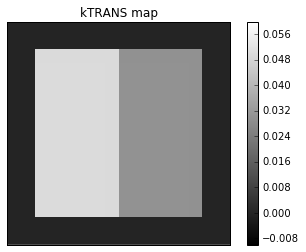

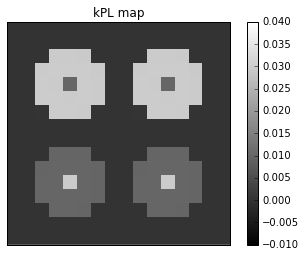

In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.optimize as optimization
from math import sqrt
%matplotlib inline
import scipy.io


def sphere(x, y, z, radius, x0, y0, z0):
    return 1.0*((x-x0)**2 + (y-y0)**2 + (z-z0)**2 < (radius)**2)

def rectangle(x, y, z, Lx, Ly, Lz, x0, y0, z0):
    return ((numpy.abs(x-x0)<Lx/2*numpy.ones(x.shape))*(numpy.abs(y-y0)<Ly/2*numpy.ones(y.shape)) * (numpy.abs(y-y0)<Ly/2*numpy.ones(z.shape)))

def dynamic_phantom(nx, ny, nz, kTRANS_low, kTRANS_high, kPL_low, kPL_high):
    x = numpy.linspace(-1, 1, nx)
    y = numpy.linspace(-1, 1, ny)
    z = numpy.linspace(-1, 1, nz)
    
    X, Y, Z = numpy.meshgrid(x, y, z)
    
    kTRANS = numpy.zeros(X.shape)
    kTRANS += kTRANS_low*rectangle(X, Y, Z, 0.8, 1.6, 1.6, 0.4, 0, 0)
    kTRANS += kTRANS_high*rectangle(X, Y, Z, 0.8, 1.6, 1.6, -0.4, 0, 0)
    
    kPL = numpy.zeros(X.shape)
    kPL += kPL_low*sphere(X, Y, Z, 0.35, 0.45, 0.45, 0) + (kPL_high - kPL_low)*sphere(X, Y, Z, 0.10, 0.45, 0.45, 0)
    kPL += kPL_low*sphere(X, Y, Z, 0.35, -0.45, 0.45, 0) + (kPL_high - kPL_low)*sphere(X, Y, Z, 0.10, -0.45, 0.45, 0)
    kPL += kPL_high*sphere(X, Y, Z, 0.35, 0.45, -0.45, 0) + (kPL_low - kPL_high)*sphere(X, Y, Z, 0.10, 0.45, -0.45, 0)
    kPL += kPL_high*sphere(X, Y, Z, 0.35, -0.45, -0.45, 0) + (kPL_low - kPL_high)*sphere(X, Y, Z, 0.10, -0.45, -0.45, 0)    
    
    return kTRANS, kPL

kTRANS_true, kPL_true = dynamic_phantom(16, 16, 16, 0.03, 0.05, 0.01, 0.03)

plt.imshow(kTRANS_true[:, :,8], cmap="gray", vmin=-1e-2, vmax=6e-2, interpolation="none")
plt.xticks([])
plt.yticks([])
plt.title("kTRANS map")
plt.colorbar()
plt.savefig('ground_truth_kTRANS.png', bbox_inches='tight')
plt.show()

plt.imshow(kPL_true[:, :,8], cmap="gray", vmin=-1e-2, vmax=4e-2, interpolation="none")
plt.xticks([])
plt.yticks([])
plt.title("kPL map")
plt.colorbar()
plt.savefig('ground_truth_kPL.png', bbox_inches='tight')
plt.show()

In [2]:
def trajectories(kTRANS, kPL, params, Mzscale, Sscale, u): 
    # FUNCTION TRAJECTORIES computes trajectories of the model 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    Ad = numpy.eye(2) + dt*numpy.array([[-kPL-R1P, 0],[kPL, -R1L]]) 
    
    x = numpy.zeros((2, N+1))
    x[0, 0] = P0
    for t in range(N):
        x[:, t+1] = numpy.dot(Ad, Mzscale[:, t]*x[:, t])  + dt*u[t]*numpy.array([kTRANS, 0])
        
    y = x[:, :-1]*Sscale
    return x[:, :-1].T

In [3]:
# setup model parameters 
dt      = 2.0
R1L     = 1.0/30.0
R1P     = 1.0/30.0
P0      = 0
sigma   = 3000.0
N       = 21
Nz      = 16
params  = numpy.array([dt, N, R1L, R1P, P0, sigma])


filename = 'bbepi_20161026'
matlab_data = scipy.io.loadmat(filename + '.mat')
data = numpy.zeros((16, 16, 21, 16, 2))
data[:, :, :, :, 0] = matlab_data['pa']
data[:, :, :, :, 1] = matlab_data['lac']
data = numpy.transpose(data, (0, 1, 3, 2, 4))

flips = matlab_data['flips']
print data.shape

print data.shape

Sscale = numpy.sin(numpy.pi/180*flips)
Mzscale = numpy.cos(numpy.pi/180*flips)

A0 = 100
t0 = 0
gamma = 2.14
beta = 3.47
t = numpy.linspace(0, N-1, N)
u = A0*(t - t0)**gamma*numpy.exp(-(t-t0)/beta)


def generate_simulated_data(kTRANS_map, kPL_map):
    assert kTRANS_map.shape == kPL_map.shape
    y = numpy.zeros(kTRANS_map.shape + (N, 2))
    for j in range(kTRANS_map.shape[0]):
        for k in range(kTRANS_map.shape[1]):
            for l in range(kTRANS_map.shape[2]):
                y[j, k, l, :, :] = trajectories(kTRANS_map[j, k, l], kPL_map[j, k, l], params, Mzscale, Sscale, u)
    return y

def compute_noise_standard_deviation(y, desired_lactate_SNR):
    signal = numpy.amax(y[:, :, :, :, 1])
    return signal/desired_lactate_SNR

def add_noise(y, noise_standard_deviation):
    return y + noise_standard_deviation*numpy.random.normal(0, 1, y.shape)

def lactate_SNR(y, noise_standard_deviation):
    signal = numpy.amax(y[:, :, :, :, 1])
    return signal/noise_standard_deviation

desired_lactate_SNR = 2.0
y_sim_truth = generate_simulated_data(kTRANS_true, kPL_true)
noise_standard_deviation = compute_noise_standard_deviation(y_sim_truth, desired_lactate_SNR)
y_sim = add_noise(y_sim_truth, noise_standard_deviation)


print y_sim.shape 

data = y_sim

print "max lactate SNR =", lactate_SNR(y_sim_truth, noise_standard_deviation)

(16, 16, 16, 21, 2)
(16, 16, 16, 21, 2)
(16, 16, 16, 21, 2)
max lactate SNR = 2.0


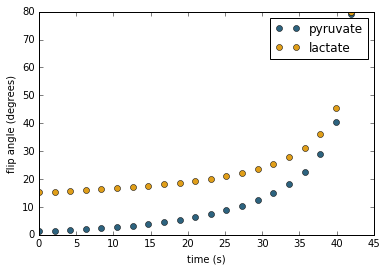

In [4]:
# berkeley_blue = RGB((1/256*[ 45.,  99., 127.])...)
# berkeley_gold = RGB((1/256*[224., 158.,  25.])...)

berkeley_blue = "#2D637F"
berkeley_gold = "#E09E19"

plt.plot(dt*numpy.linspace(0, flips.shape[1], flips.shape[1]), flips[0, :], 'o', color=berkeley_blue)
plt.plot(dt*numpy.linspace(0, flips.shape[1], flips.shape[1]), flips[1, :], 'o', color=berkeley_gold)
plt.legend(["pyruvate", "lactate"])
plt.xlabel("time (s)")
plt.ylabel("flip angle (degrees)")
plt.savefig("T1_effective_flip_angles.pdf")
plt.show()

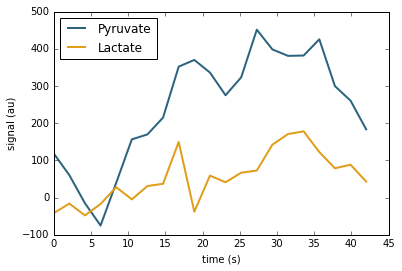

('kTRANS =', 0.050000000000000003, 'kPL =', 0.029999999999999999)


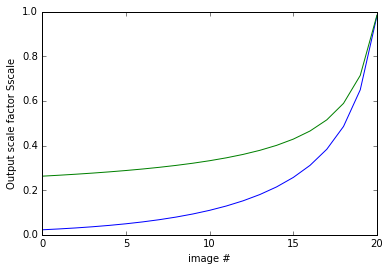

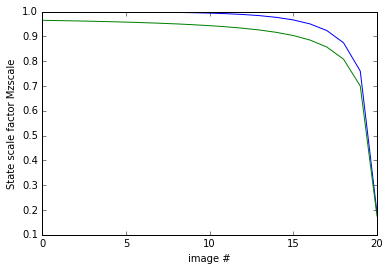

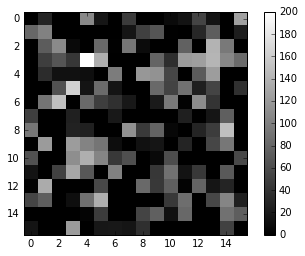

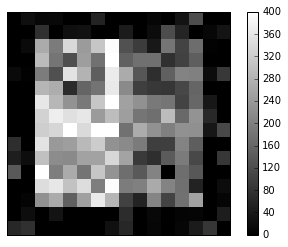

In [5]:

# Sscale  = numpy.diag([numpy.sin(7*numpy.pi/180), numpy.sin(35*numpy.pi/180)]).dot(numpy.ones((2, N)))
# Mzscale = numpy.diag([numpy.cos(7*numpy.pi/180), numpy.cos(35*numpy.pi/180)]).dot(numpy.ones((2, N)))

# plot time series from a particular voxel 
plt.plot(dt*numpy.linspace(0, N, N), data[3, 3, 8, :, 0], '-', linewidth=2, color=berkeley_blue)
plt.plot(dt*numpy.linspace(0, N, N), data[3, 3, 8, :, 1], '-', linewidth=2, color=berkeley_gold)
plt.legend(('Pyruvate', 'Lactate'), loc='upper left')
plt.xlabel('time (s)')
plt.ylabel('signal (au)')
plt.savefig('simulated_data_time_series.png', bbox_inches='tight')
plt.show()
print("kTRANS =", kTRANS_true[3, 3, 8], "kPL =", kPL_true[3, 3, 8])

# plot Sscale (output scale factor) corresponding to flip angle sequence
plt.plot(Sscale.T)
plt.xlabel('image #')
plt.ylabel('Output scale factor Sscale')
plt.show()

# plot Mzscale (state scale factor) corresponding to flip angle sequence
plt.plot(Mzscale.T)
plt.xlabel('image #')
plt.ylabel('State scale factor Mzscale')
plt.show()

# plot pyruvate data at some time 
# plt.figure(figsize = (15,15))
# for i in range(Nz):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(data[:, :, i, -1, 0], cmap="gray", vmin=0, vmax=1e3, interpolation="nearest")
#     #plt.xticks([])
#     #plt.yticks([])
#     plt.colorbar()
#     plt.title("layer " + str(i+1))
# plt.savefig('pc_data_3D_pyruvate_images.png', bbox_inches='tight')
# plt.show()

# plot lactate data at some time 
# plt.figure(figsize = (15,15))
# for i in range(Nz):
#     plt.subplot(4, 4, i+1)
#     plt.imshow(data[:, :, i, -1, 1], cmap="gray", vmin=0, vmax=2e2, interpolation="nearest")
#    #plt.xticks([])
#    #plt.yticks([])
#    plt.colorbar()
#    plt.title("layer " + str(i+1))
# plt.savefig('pc_data_3D_lactate_images.png', bbox_inches='tight')
# plt.show()

slice_no = 8
plt.imshow(data[:, :, slice_no, -1, 0], cmap="gray", vmin=0, vmax=2e2, interpolation="nearest")
#plt.xticks([])
#plt.yticks([])
plt.colorbar()
plt.savefig('simulated_data_pyruvate_slice.png', bbox_inches='tight')
plt.show()

plt.imshow(data[:, :, slice_no, -1, 1], cmap="gray", vmin=0, vmax=4e2, interpolation="nearest")
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.savefig('simulated_data_lactate_slice.png', bbox_inches='tight')
plt.show()

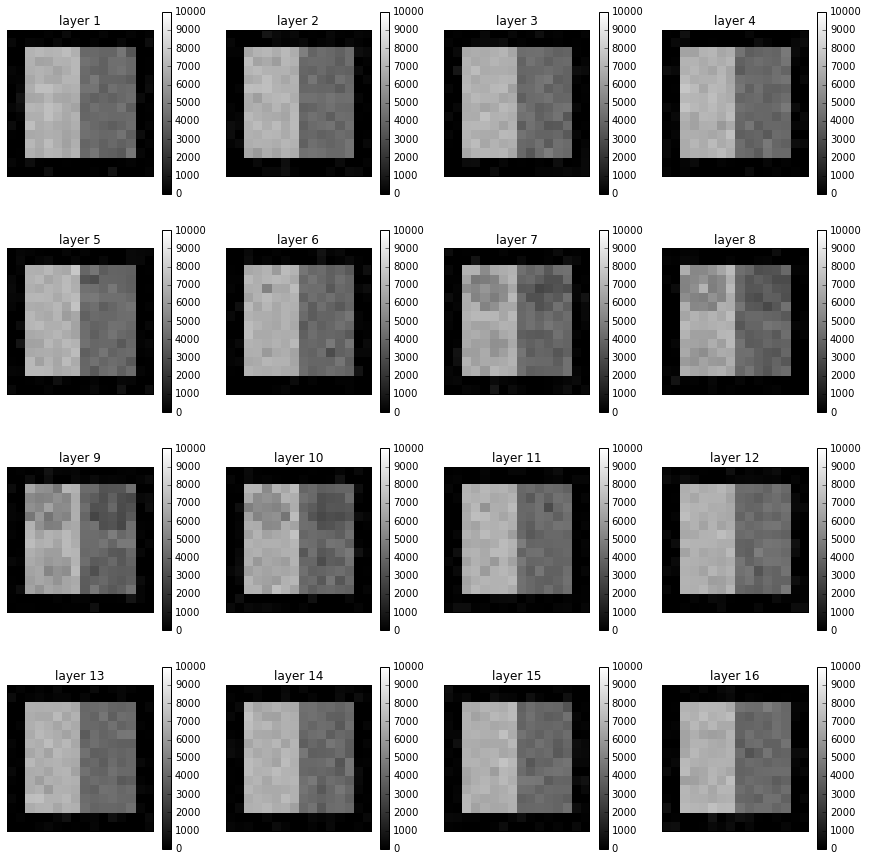

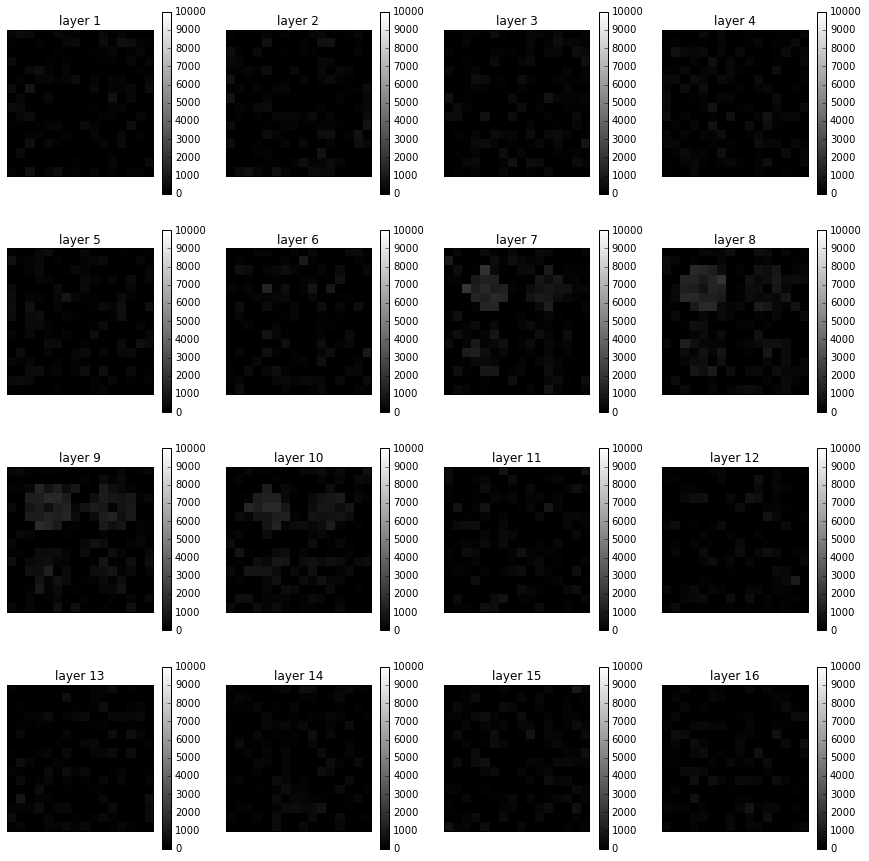

In [6]:
# result of temporal averaging (Area under the curve)

# pyruvate
plt.figure(figsize = (15, 15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(numpy.sum(data[:, :, i, :, 0], 2), cmap="gray", vmin=0, vmax=1e4, interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
plt.show()

# lactate
plt.figure(figsize = (15, 15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(numpy.sum(data[:, :, i, :, 1], 2), cmap="gray", vmin=0, vmax=1e4, interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
plt.show()

In [7]:
# Define functions for fitting model to data 
    
def traj_1D(kPL, params, Mzscale, Sscale, y1):
    
    # y1 should be the (unscaled) output data from the pyruvate channel
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    x1 = y1/Sscale[0, :]
        
    x2 = numpy.zeros(N) 
    for t in range(N-1):
        x2[t+1] = (-(kPL*numpy.exp((- R1P - kPL)*dt) - kPL*numpy.exp(-R1L*dt))/(R1P - R1L + kPL))*Mzscale[0, t]*x1[t]  +  numpy.exp(-R1L*dt)*Mzscale[1, t]*x2[t]
    return x2*Sscale[1, :]

def maximum_likelihood_fit(data, params, Mzscale, Sscale, u): 
    # data represents times series from a particular voxel 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
        
    def func(theta, params, Y):
        return (Y - trajectories(theta[0], theta[1], params, Mzscale, Sscale, u)).flatten()
    
    # res = optimization.curve_fit(func, xdata, ydata, x0, sigma)
    x0  = numpy.array([0.05, 0.07])
    res = optimization.leastsq(func, x0, args=(params, data))

    return res[0]

def assumptionless_fit(data, params, Mzscale, Sscale):
    
    assert(len(params) == 6)
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    def func(theta, params, data):
        return (data[:, 1] - traj_1D(theta, params, Mzscale, Sscale, data[:, 0]))
    
    theta0  = numpy.array([0.07])
    res = optimization.leastsq(func, theta0, args=(params, data))

    return res[0]

In [8]:
# loop assumptionless fit
def loop_assumptionless_fit(data, params, Mzscale, Sscale):
    kPL_fit_array = numpy.zeros(data.shape[0:3])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                kPL_fit_array[i, j, k] = assumptionless_fit(data[i, j, k, :, :], params, Mzscale, Sscale)
    return kPL_fit_array
                
# test this function 
kPL_fit = loop_assumptionless_fit(data, params, Mzscale, Sscale)

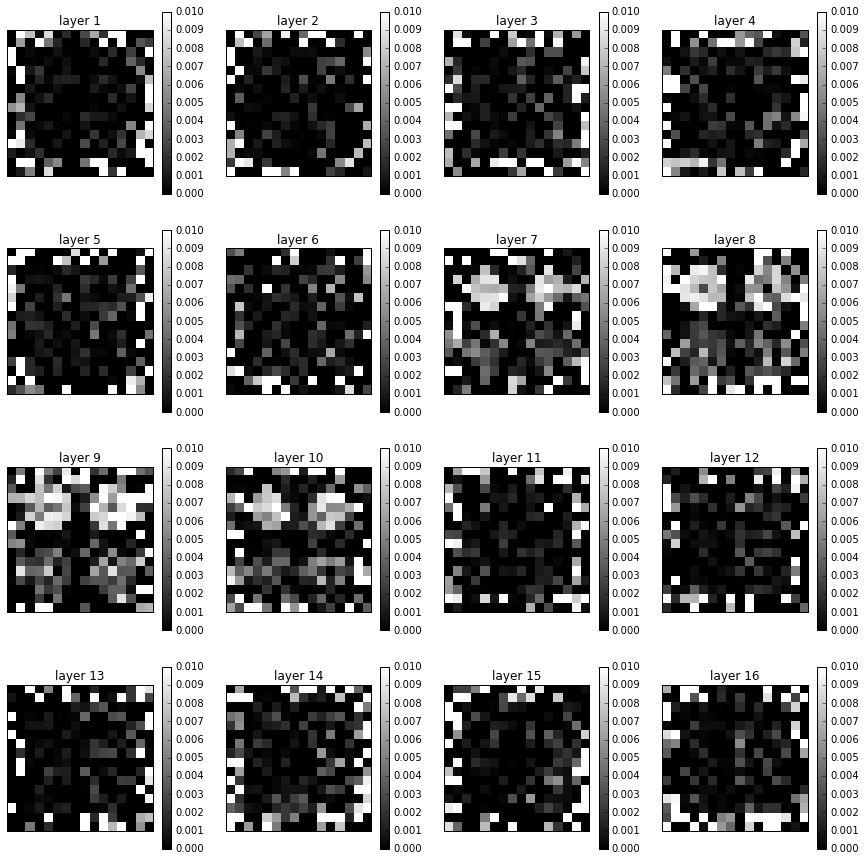

In [9]:
# plot results of independent voxel-wise fit 

plt.figure(figsize = (15,15))
for i in range(Nz):
    plt.subplot(4, 4, i+1)
    plt.imshow(kPL_fit[:, :, i], cmap="gray", vmin=0, vmax=1e-2, interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.title("layer " + str(i+1))
plt.savefig('pc_data_3D_kPL_map_no_regularization.png', bbox_inches='tight')
plt.show()

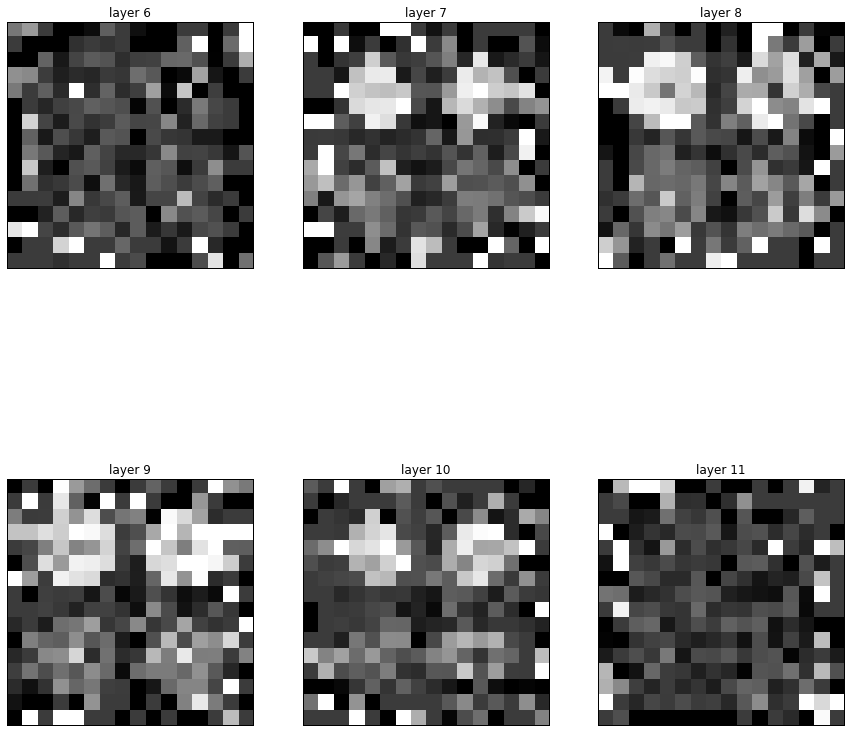

In [10]:
# plot results of independent voxel-wise fit masked based on perfusion threshold

def compute_mask(data, threshold):
    return (numpy.sum(numpy.abs(data[:, :, :, :, 0]), 3) > threshold)
    
mask = compute_mask(data, 1e3) # set threshold here 

plt.figure(figsize = (15, 15))
for i in range(5, 11):
    plt.subplot(2, 3, i-4)
    plt.imshow(mask[:, :, i]*kPL_fit[:, :, i], cmap="gray",  vmin=-3e-3, vmax=1e-2, interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
    plt.title("layer " + str(i+1))
plt.savefig('pc_data_3D_kPL_map_no_regularization_pefusion_thresholded.png', bbox_inches='tight')
plt.show()

In [11]:
## ADMM / Douglas-Rachford algorithm for parameter mapping 

import prox_tv as ptv

def theta_step_assumptionless(data, theta, z, u, rho, params, lambda2, Mzscale, Sscale): 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    def func(theta, params, data):
        return numpy.hstack((data[:, 1] - traj_1D(theta, params, Mzscale, Sscale, data[:, 0]) , sqrt(0.5*rho)*(theta - z + u), sqrt(lambda2)*theta))
    
    theta0  = numpy.array([0.07])
    res = scipy.optimize.leastsq(func, theta0, args=(params, data))

    return res[0]

def theta_step_linear_least_squares(data, theta, z, u, rho, params): 
    # data represents times series from a particular voxel 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    # extract relevant vectors 
    P_t      = data[:-1, 0]
    L_t      = data[:-1, 1]
    L_tplus1 = data[1:, 1]
        
    # set up A*theta = b 
    b = L_tplus1 - L_t + dt*R1L*L_t
    A = dt*P_t 
            
    # compute prox operator for 1/2 |A*theta - b|_2^2 
    M = (1/rho)*numpy.dot(A, A.T) + 1.0
    c = (1/rho)*numpy.dot(A, b.T) + z - u
    return c/M

def theta_step_maximum_likelihood(data, theta, z, u, rho, params, lambda2, Mzscale, Sscale, u0): 
    # data represents times series from a particular voxel 
    
    # unpack params 
    dt    = params[0]
    N     = int(params[1])
    R1L   = params[2]
    R1P   = params[3]
    P0    = params[4]
    sigma = params[5]
    
    def func(theta, params, Y, Mzscale, Sscale, u0):
        return numpy.hstack(((Y - trajectories(theta[0], theta[1], params, Mzscale, Sscale, u0)).flatten(), sqrt(0.5*rho)*(theta[1]- z + u), sqrt(lambda2)*theta[1]))

    x0  = numpy.array([0.05, 0.07])
    res = scipy.optimize.leastsq(func, x0, args=(params, data, Mzscale, Sscale, u0))

    return res[0][1]

def z_step(theta, z, u, lambda1, rho):    
    # return ptv.tv1_2d(rho/(2*lambda2 + rho)*(theta + u), lambda1/(lambda2 + 0.5*rho), n_threads=1)
    # return ptv.tv1_2d(theta + u, lambda1/rho, n_threads=1)
    return ptv.tvgen(theta + u, numpy.array([lambda1/rho, lambda1/rho, lambda1/rho]), [1, 2, 3], numpy.array([1, 1, 1]))

def u_step(theta, z, u):  
    return u + theta - z

## Prepare and test parallel map function 
import ipyparallel as ipp
c = ipp.Client()
dview = c[:]

with dview.sync_imports():
    import numpy
    import scipy
    import scipy.optimize

def pmap_ndarray(direct_view, f, *args):
    
    shape = args[0].shape
    
    # flatten arguments
    flattened_args = []
    for arg in args:
        assert(arg.shape == shape) # check that all args are the same shape 
        flattened_args.append(arg.flatten())
        
    # apply map function 
    y = direct_view.map_sync(f, *flattened_args)
    
    # reshape result to match shape of args
    return numpy.array(y).reshape(shape)

importing numpy on engine(s)
importing scipy on engine(s)
importing scipy.optimize on engine(s)


In [12]:
def ADMM_parallel_3D(data, lambda1, lambda2, rho, theta_est, z_est, u_est, method):
    theta = theta_est*numpy.ones((numpy.shape(data)[0], numpy.shape(data)[1], numpy.shape(data)[2]))
    z     =     z_est*numpy.ones((numpy.shape(data)[0], numpy.shape(data)[1], numpy.shape(data)[2]))
    u     =     u_est*numpy.ones((numpy.shape(data)[0], numpy.shape(data)[1], numpy.shape(data)[2]))
    
    # convert data to mappable format
    data_abstract = numpy.zeros(data.shape[0:3], dtype=numpy.ndarray)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                data_abstract[i, j, k] = data[i, j, k, :, :]
    
    # iterate ADMM until convergence, or until we reach max_iter iterations 
    max_iters = 20
    min_iters = 10
    iterations = 0
    epsilon = 1e-3
    
    # theta_step_vectorized = numpy.vectorize(lambda w, x, y, z: theta_step(w, x, y, z, rho, params))
    u_step_vectorized = numpy.vectorize(u_step)
    
    # broadcast and load required packages, functions, variables 
    dview.push(dict(theta_step_linear_least_squares=theta_step_linear_least_squares, 
                    theta_step_maximum_likelihood=theta_step_maximum_likelihood,
                    theta_step_assumptionless=theta_step_assumptionless,
                    Mzscale=Mzscale,
                    Sscale=Sscale,
                    trajectories=trajectories,
                    traj_1D=traj_1D,
                    sqrt=sqrt,
                    params=params))
    
    while (iterations < min_iters): 
        if (method == "linear-least-squares"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_linear_least_squares(w, x, y, z, rho, params, lambda2), data_abstract, theta, z, u)
        elif (method == "maximum-likelihood"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_maximum_likelihood(w, x, y, z, rho, params, lambda2, Mzscale, Sscale, u0), data_abstract, theta, z, u)
        elif (method == "assumption-less"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_assumptionless(w, x, y, z, rho, params, lambda2, Mzscale, Sscale), data_abstract, theta, z, u)
        else:
            raise ValueError("estimation method '%s' is not defined"%method)
        z     = z_step(theta, z, u, lambda1, rho)
        u     = u_step_vectorized(theta, z, u) # this can be parallelized too if we want, but it's fast
        iterations += 1
    
    while ((iterations < max_iters) and (numpy.linalg.norm(theta - z) > epsilon)):
        if (method == "linear-least-squares"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_linear_least_squares(w, x, y, z, rho, params, lambda2), data_abstract, theta, z, u)
        elif (method == "maximum-likelihood"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_maximum_likelihood(w, x, y, z, rho, params, lambda2, Mzscale, Sscale, u0), data_abstract, theta, z, u)
        elif (method == "assumption-less"):
            theta = pmap_ndarray(dview, lambda w, x, y, z: theta_step_assumptionless(w, x, y, z, rho, params, lambda2, Mzscale, Sscale), data_abstract, theta, z, u)
        else:
            raise ValueError("estimation method '%s' is not defined"%method)
        z     = z_step(theta, z, u, lambda1, rho)
        u     = u_step_vectorized(theta, z, u) # this can be parallelized too if we want, but it's fast
        iterations += 1

    print "iterations = ", iterations
    
    return theta

In [13]:
TV_regularization = 10e05
l2_regularization = 1e08
rho = 1e10
kPL_map = ADMM_parallel_3D(data, TV_regularization, l2_regularization, rho, 0.0, 0.0, 0.0, "assumption-less")

iterations =  10


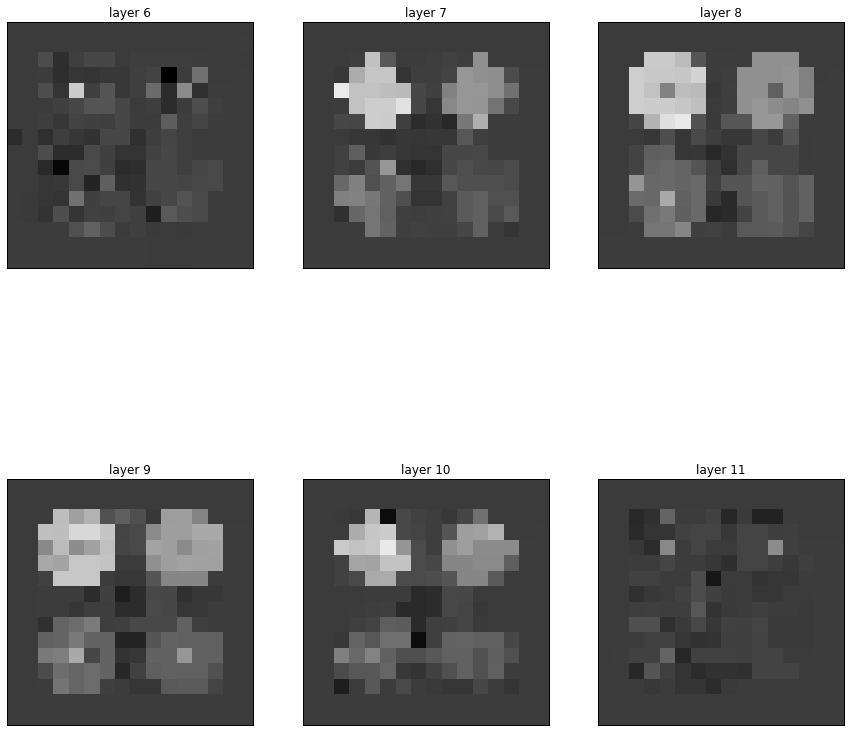

In [14]:
# plot slices of 3D parameter map 

plt.figure(figsize = (15,15))
for i in range(5, 11):
    plt.subplot(2, 3, i-4)
    plt.imshow(kPL_map[:, :, i], cmap="gray", vmin=-3e-3, vmax=1e-2, interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
    plt.title("layer " + str(i+1))
plt.savefig('pc_data_3D_kPL_map_optimal_regularization.png', bbox_inches='tight')
plt.show()

In [15]:
# save computed parameter map in matlab format 
scipy.io.savemat('kPL_map_' + filename + '.mat', {"kPL_map": kPL_map})

In [37]:
def hyperparameter_selection(lambdas):
    
    results = numpy.zeros((len(lambdas[0]), len(lambdas[1])) + kPL_map.shape)
    
    for j, TV_regularization in enumerate(lambdas[0]):
        for k, l2_regularization in enumerate(lambdas[1]):
            print (j, k)
            # rho = 100*TV_regularization
            kPL = ADMM_parallel_3D(data, TV_regularization, l2_regularization, rho, 0.0, 0.0, 0.0, "assumption-less")
            results[j, k, :, :, :] = kPL
            
    return results

def metrics(results, kPL_true):
    l2_metric = numpy.zeros(results.shape[:2])
    l1_metric = numpy.zeros(results.shape[:2])
    for j in range(results.shape[0]):
        for k in range(results.shape[1]):
            l2_metric[j, k] = numpy.linalg.norm((kPL_true - results[j, k, :, :, :]).flat[:], 2)
            l1_metric[j, k] = numpy.linalg.norm((kPL_true - results[j, k, :, :, :]).flat[:], 1)
            
    return l2_metric, l1_metric

In [107]:
lambdas = [numpy.logspace(4, 8, 9), numpy.logspace(6, 10, 9)]
results = hyperparameter_selection(lambdas)
metric = metrics(results, kPL_true)

(0, 0)
iterations =  10
(0, 1)
iterations =  10
(0, 2)
iterations =  10
(0, 3)
iterations =  10
(0, 4)
iterations =  10
(0, 5)
iterations =  10
(0, 6)
iterations =  10
(0, 7)
iterations =  10
(0, 8)
iterations =  10
(1, 0)
iterations =  10
(1, 1)
iterations =  10
(1, 2)
iterations =  10
(1, 3)
iterations =  10
(1, 4)
iterations =  10
(1, 5)
iterations =  10
(1, 6)
iterations =  10
(1, 7)
iterations =  10
(1, 8)
iterations =  10
(2, 0)
iterations =  10
(2, 1)
iterations =  10
(2, 2)
iterations =  10
(2, 3)
iterations =  10
(2, 4)
iterations =  10
(2, 5)
iterations =  10
(2, 6)
iterations =  10
(2, 7)
iterations =  10
(2, 8)
iterations =  10
(3, 0)
iterations =  10
(3, 1)
iterations =  10
(3, 2)
iterations =  10
(3, 3)
iterations =  10
(3, 4)
iterations =  10
(3, 5)
iterations =  10
(3, 6)
iterations =  10
(3, 7)
iterations =  10
(3, 8)
iterations =  10
(4, 0)
iterations =  10
(4, 1)
iterations =  10
(4, 2)
iterations =  10
(4, 3)
iterations =  10
(4, 4)
iterations =  10
(4, 5)
iteration

In [108]:
L2, L1 = metrics(results, kPL_true)

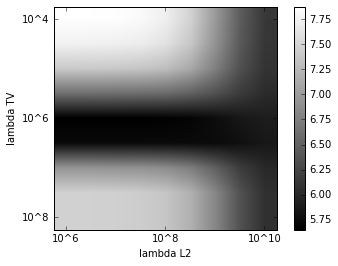

In [113]:
from matplotlib import rc
rc('text', usetex=False)

# plt.imshow(metric, cmap="gray", vmin=-3e-3, vmax=1e0, interpolation="nearest")
plt.imshow((L1[:, :]), cmap="gray")
plt.ylabel('lambda TV')
plt.xlabel('lambda L2')
plt.xticks([0, 4, 8], ["10^6", "10^8", "10^10"])
# plt.xticks([0, 2, 4], [10**6, 10**8, 10**10])
plt.yticks([0, 4, 8], ["10^4", "10^6", "10^8"])
plt.colorbar()
# plt.ticklabel_format(style='sci', axis='x')
plt.savefig('estimation_error_numeric_phantom.pdf', bbox_inches='tight')
plt.show()
